# **Introduction**

**About Dataset**

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning.

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

**Approach**

* **AttentionUNet/UNet** is the best know model for **Multi-Class Segmentation**, thats why we will be creating a **Attention UNet Model**.
* As the **image Dataset** is **old**, please **do not use it for any new medical operations**.
* All the images are of 500 X 500 pixels, **Kaggle RAM** wil not be enough so we will be resizing the Image to **256 X 256 pixels**.

**Model Architecture**

* The Model will consist of a **Encoder Block, Decoder Block and a Attention Gate.**

**Disclaimer**
* This work is derived from this [notebook](https://www.kaggle.com/code/utkarshsaxenadn/breast-cancer-image-segmentation-attention-unet).

# **Imports**

In [1]:
import os

kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)
print("Kaggle directory created at:", kaggle_dir)

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    if fn != "kaggle.json":
        os.rename(fn, "kaggle.json")
        print(f"Renamed {fn} to kaggle.json")

!cp kaggle.json {kaggle_dir}/

!chmod 600 {kaggle_dir}/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip -q breast-ultrasound-images-dataset.zip -d breast-ultrasound-images


Kaggle directory created at: /root/.kaggle


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0


In [3]:
!pip install tf_explain
from IPython.display import clear_output # Import clear_output
clear_output() # Now you can call clear_output

In [4]:
# common
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU



# **Data**

In [5]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [6]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [7]:
SIZE = 256

In [17]:
root_path = '/content/breast-ultrasound-images/Dataset_BUSI_with_GT' # Correct the root_path if necessary
if os.path.exists(root_path):
    classes = sorted(os.listdir(root_path))
else:
    print(f"Error: Directory '{root_path}' not found.")

classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [14]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [15]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [16]:
show_image(load_image(image_paths[0], SIZE))

IndexError: list index out of range

Classes found: ['benign', 'malignant', 'normal']
Found 780 images and 780 masks.


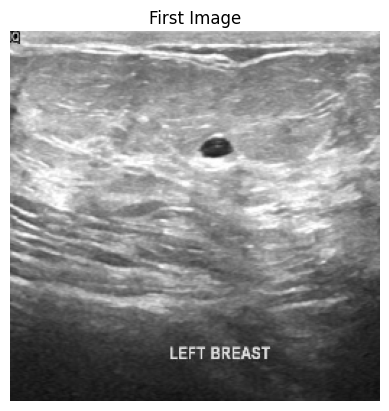

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# If using Google Colab, make sure your drive is mounted:
# from google.colab import drive
# drive.mount('/content/drive')

# --- Utility Functions ---

def load_image(image, SIZE):
    # Load image, convert to array, scale to [0, 1], and resize to (SIZE, SIZE)
    img = load_img(image)
    img_arr = img_to_array(img) / 255.
    # Use tf.image.resize for simplicity (or tfi.resize if needed)
    resized = tf.image.resize(img_arr, (SIZE, SIZE))
    return np.round(resized.numpy(), 4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        # Masks are assumed to be single-channel
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i, path in enumerate(image_paths):
        img = load_image(path, SIZE)
        if mask:
            images[i] = img[:, :, :1]  # Use only the first channel for the mask
        else:
            images[i] = img

    return images

def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.show()

# --- Configuration ---

SIZE = 256

# Set your root dataset path. Adjust as needed for your setup:
root_path = '/content/breast-ultrasound-images/Dataset_BUSI_with_GT'
if not os.path.exists(root_path):
    raise FileNotFoundError(f"Directory '{root_path}' not found. Please check your path.")

# Get classes from the subdirectories (e.g., 'normal', 'benign', 'malignant')
classes = sorted(os.listdir(root_path))
print("Classes found:", classes)

# --- File Search Setup ---

# We construct the glob pattern for each class using os.path.join for consistency
single_mask_paths = []
# Optionally, you can also handle double masks if needed
double_mask_paths = []

for class_name in classes:
    class_folder = os.path.join(root_path, class_name)

    # Find masks following the naming pattern "*_mask.png"
    pattern_mask = os.path.join(class_folder, "*_mask.png")
    masks_found = sorted(glob(pattern_mask))

    if not masks_found:
        print(f"[WARNING] No mask files found in folder: {class_folder}.")

    single_mask_paths.append(masks_found)

    # If you need to find double masks (if applicable)
    pattern_double_mask = os.path.join(class_folder, "*_mask_1.png")
    double_masks_found = sorted(glob(pattern_double_mask))
    double_mask_paths.append(double_masks_found)

# --- Building the Image and Mask Path Lists ---

image_paths = []
mask_paths = []

# Loop over the list of mask lists from each class
for masks in single_mask_paths:
    for mask_path in masks:
        # Create the corresponding image file path by removing '_mask' from the filename
        img_path = mask_path.replace('_mask', '')
        if os.path.exists(img_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"[WARNING] Image file not found for mask: {mask_path}")

print(f"Found {len(image_paths)} images and {len(mask_paths)} masks.")

# --- Displaying the First Image ---

if image_paths:
    img = load_image(image_paths[0], SIZE)
    show_image(img, title="First Image")
else:
    print("No image files found. Please verify your dataset paths and naming patterns.")


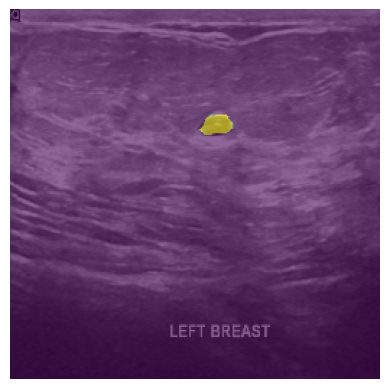

In [22]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

## **Data Work**

In [ ]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

In [ ]:
images, test_images = train_test_split(images, test_size=0.15, random_state=42)
masks, test_masks = train_test_split(masks, test_size=0.15, random_state=42)

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

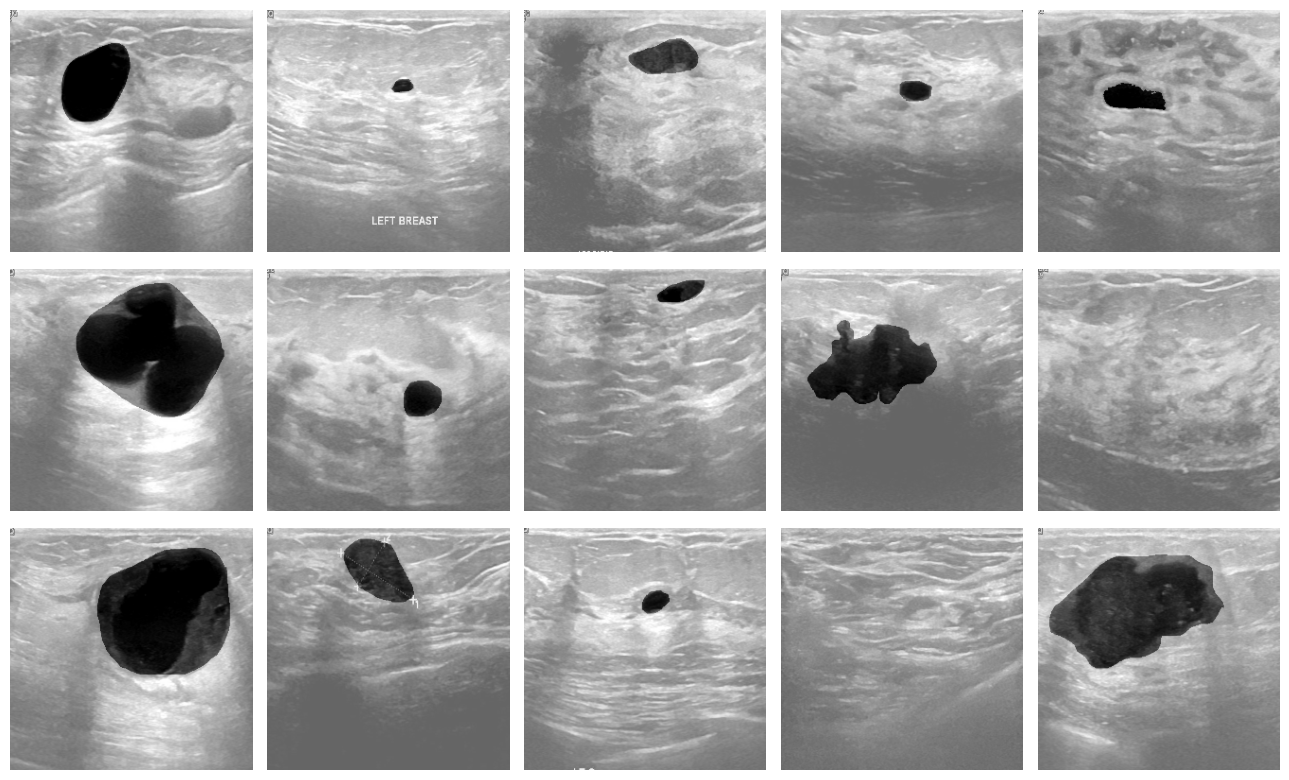

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

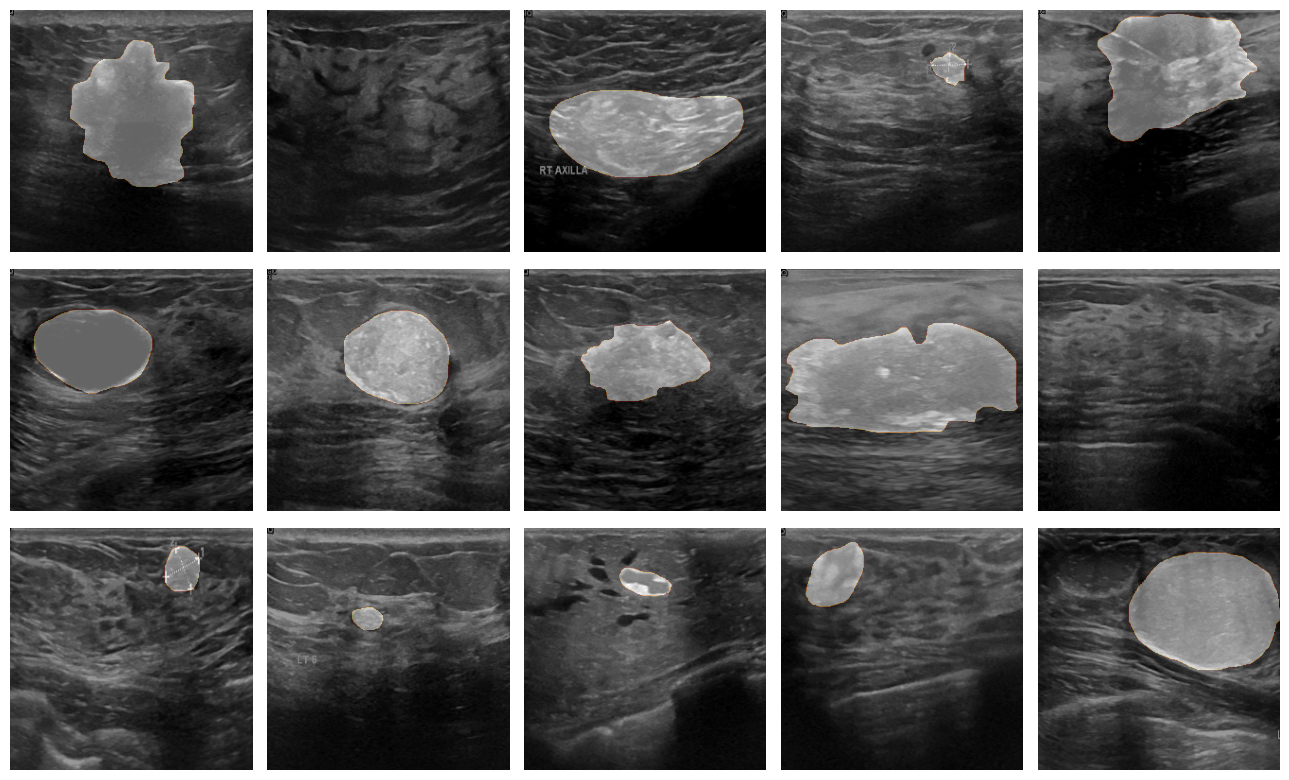

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

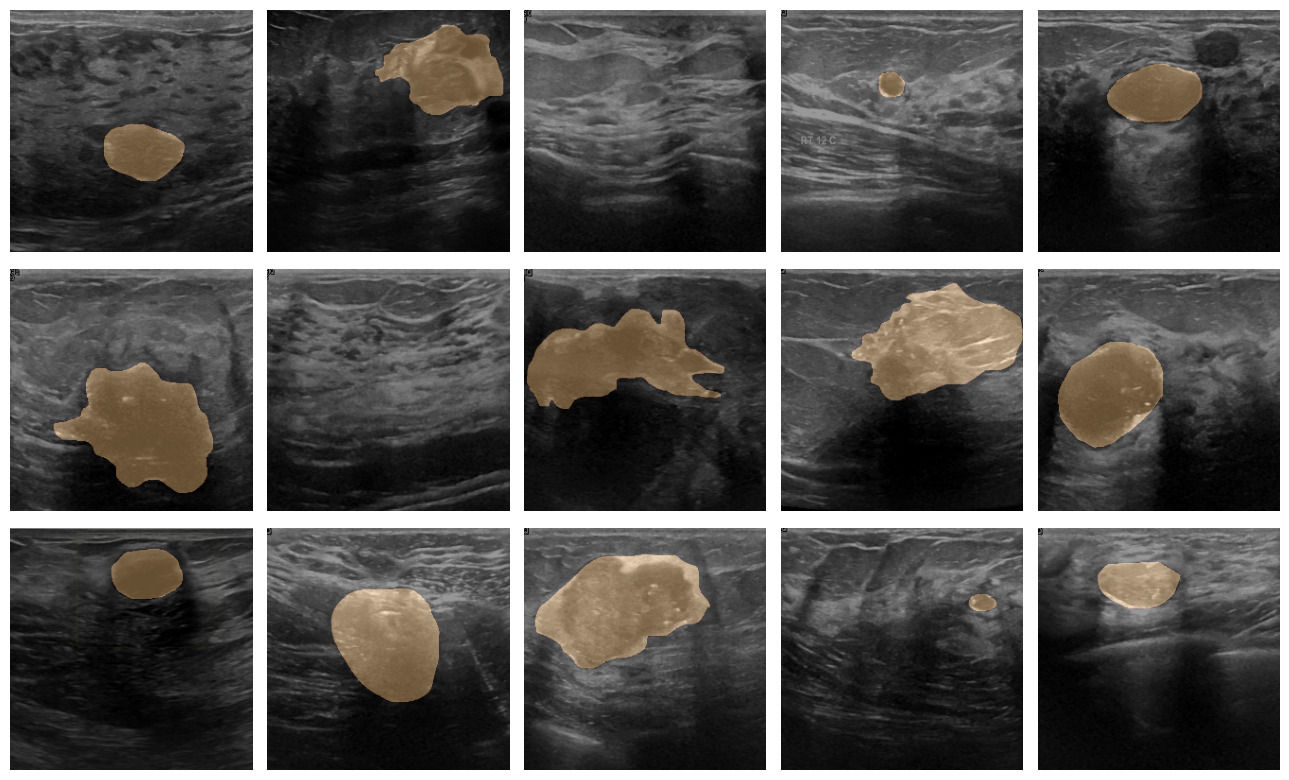

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [ ]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = Conv2DTranspose(
                                 filters,    # number of filters
                                 kernel_size=3,    # Kernel size
                                 strides=2,
                                 padding='same')
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Custom Callback**

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

# **Attention UNet**

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.3, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

# **Training**

Epoch 1/20
82/82 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9153 - IoU: 0.4641 

1/1 [==============================] - 2s 2s/step


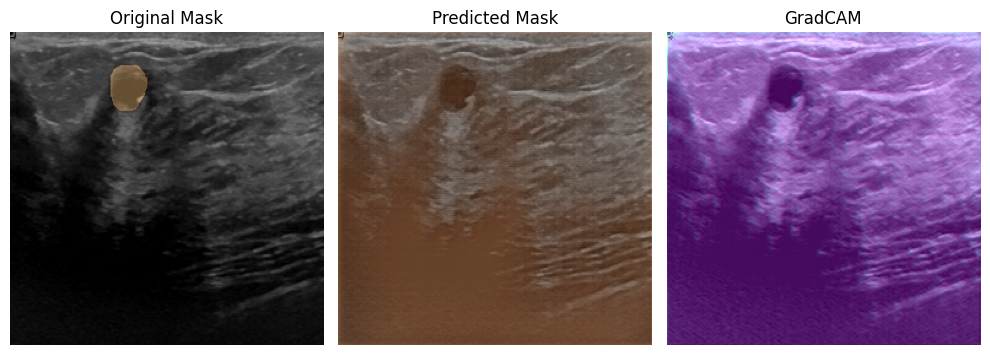

82/82 [==============================] - 1762s 21s/step - loss: 0.2567 - accuracy: 0.9153 - IoU: 0.4641 - val_loss: 0.3625 - val_accuracy: 0.9133 - val_IoU: 0.4578
Epoch 2/20
82/82 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9219 - IoU: 0.4618 

1/1 [==============================] - 1s 1s/step


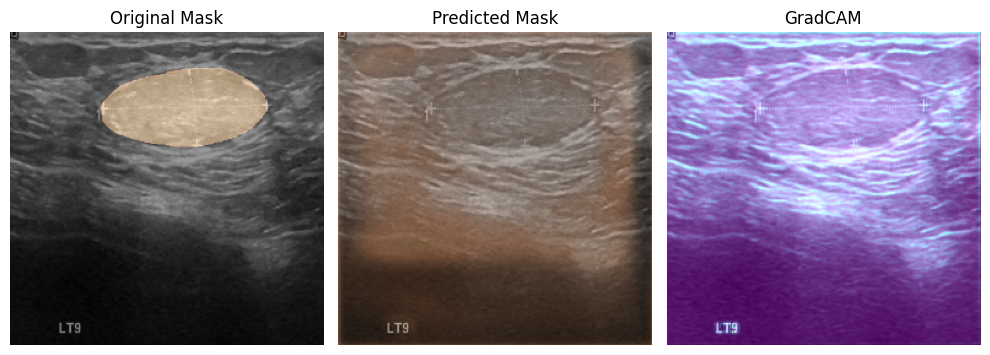

82/82 [==============================] - 1676s 20s/step - loss: 0.2244 - accuracy: 0.9219 - IoU: 0.4618 - val_loss: 0.2947 - val_accuracy: 0.9133 - val_IoU: 0.4578
Epoch 3/20
 8/82 [=>............................] - ETA: 24:18 - loss: 0.1988 - accuracy: 0.9300 - IoU: 0.4657

In [ ]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE


# Training
results = model.fit(
    images, masks,
    validation_split=0.15,
    epochs=20,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

**Observations :**

* After **12 epochs** model started outputting what we needed.
* The model was easily able to detect **black round spots but fails when the shape is irregular**(Not the case with current model because it is trained with hight SPE).

* It also gets confused between the dark areas, which makes sense.

---
**Suggestion :**
* Do training in chunks of **20 Epochs**, this will give you a good control **over model and the model will also perform well**.

* Here the model is trained on 17 + 17 + 17 = 51 Epochs.

* If you give the model a closer look n different images you will find that the model fails at some images, but I can garantee that 9/10 such images would be so tough that even a human will not be a able to detect as many parts of the image look the same.


# **Evaluation**

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

Suprisingly the results on **Validation Data** are **way better** than the results on **Trainind Data** on **IoU**, this may indicate that the **model can perform way better** than what it can do at the current point. The **Loss is not Perfect** it increases in the last but the model constructions are loooking perfect as this point, that's why **I believe in what I see**. This model seems promising, let's try it on some Images.

1/1 [==============================] - 0s 33ms/step


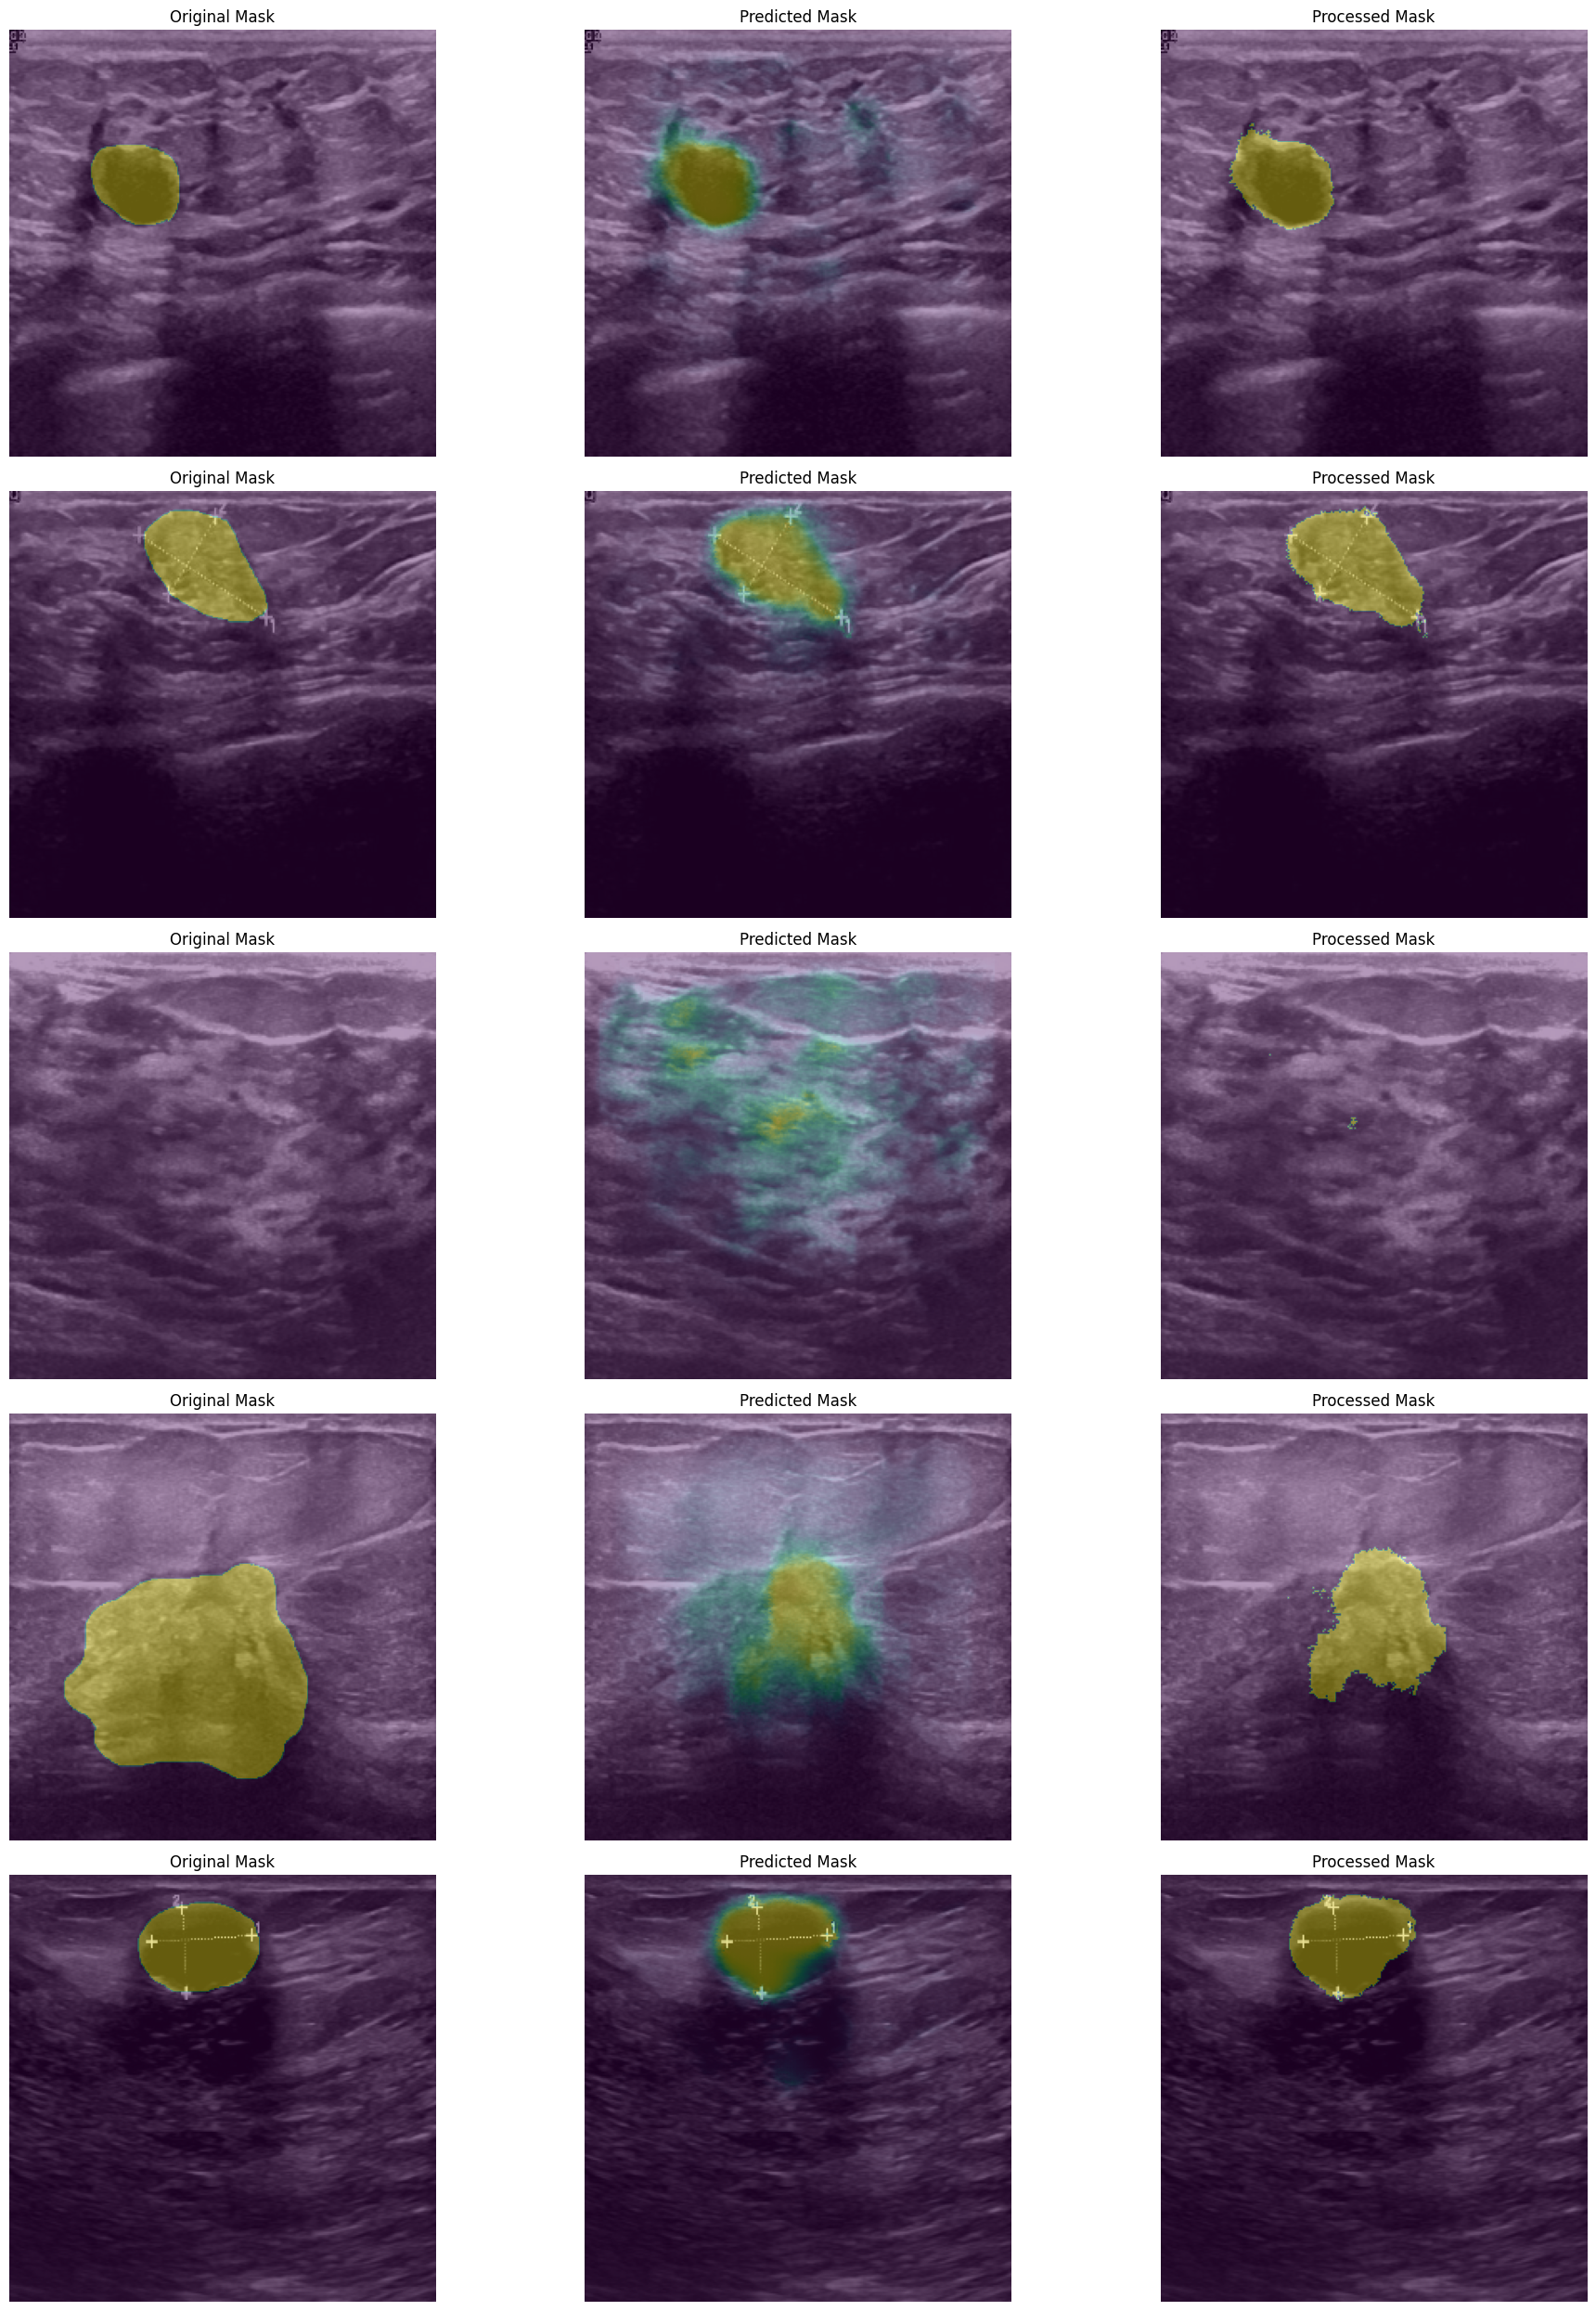

In [ ]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
model.evaluate(test_images, test_masks)

4/4 [==============================] - 22s 3s/step - loss: 0.1550 - accuracy: 0.9478 - IoU: 0.4633


[0.15500488877296448, 0.9478162527084351, 0.4633471667766571]

# Model Quantization

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(images).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [np.float32(input_value)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
import pathlib

#save model
tflite_model_file = pathlib.Path('/kaggle/working/cnn_model_quant.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

In [ ]:
# Get input/output layer information
i_details = interpreter.get_input_details()[0]
o_details = interpreter.get_output_details()[0]
i_shape = i_details['shape']

interpreter.allocate_tensors()

In [ ]:
from tqdm.notebook import tqdm

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

predictions = []
for i in tqdm(range(len(test_images))):
    image = test_images[i]
    image = np.expand_dims(image, axis=0).astype(input_type)
    interpreter.set_tensor(input_details["index"], image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    output = (output>0.5).astype('float')

    predictions.append(output)

In [ ]:
m = tf.keras.metrics.Accuracy()
m.reset_state()
m.update_state(test_masks, predictions)
result = m.result().numpy()
print(result)

In [ ]:
plt.figure(figsize=(20,25))

plt.subplot(1,2,1)
plt.title("Original Mask")
show_mask(image, mask)

plt.subplot(1,2,2)
plt.title("Quantized Mask")
show_mask(i_value[0], m_value)

In [ ]:
m.update_state(test_masks, pred_masks)
result = m.result().numpy()
print(result)